In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2

## Data Preprocessing

In [2]:
train_data_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
validation_data_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

IMG_SIZE = [224, 224]
INIT_LR = 1e-4
EPOCHS = 20
BS = 64

train_datagen = ImageDataGenerator(rescale = 1./225,
                                  samplewise_center = True,
                                   samplewise_std_normalization = True,
                                  rotation_range = 10,
                                  horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./225)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(IMG_SIZE),
                                                        batch_size = 64,
                                                        shuffle = True,
                                                        class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory(directory = validation_data_dir,
                                                        target_size = tuple(IMG_SIZE),
                                                        batch_size = 64,
                                                        shuffle = False,
                                                        class_mode = 'categorical')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Data Visualization

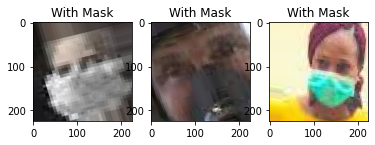

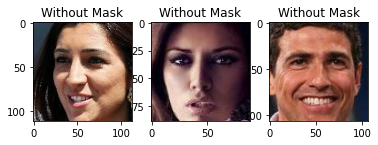

In [3]:
masked_images = os.listdir('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask')
unmasked_images = os.listdir('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask')

plt.figure(figsize = (6, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_data_dir + "/WithMask",masked_images[i])))
    plt.title("With Mask")

plt.figure(figsize = (6, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_data_dir + "/WithoutMask",unmasked_images[i])))
    plt.title("Without Mask")

## Transfer Learning - Loading MobileNetV2 Architechure
### Model Prepration

In [4]:
mobilenet = MobileNetV2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
for layer in mobilenet.layers:
    layer.trainable = False
    
#mobilenet.summary()

9412608/9406464 [==============================] - 0s 0us/step


### Adding Base Layers to the Model

In [5]:
X = AveragePooling2D(pool_size=(7, 7))(mobilenet.output)
X = Flatten(name="flatten")(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
prediction = Dense(2, activation= 'softmax')(X)
model = Model(inputs = mobilenet.input, outputs = prediction)
# model.summary()

## Model Compilation 

In [6]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

## Model Training

In [7]:
history = model.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data= val_generator,
                    verbose = 1)

Epoch 1/20
157/157 [==============================] - 186s 1s/step - loss: 0.4254 - accuracy: 0.8328 - val_loss: 0.1251 - val_accuracy: 0.9613
Epoch 2/20
157/157 [==============================] - 127s 811ms/step - loss: 0.1047 - accuracy: 0.9714 - val_loss: 0.0787 - val_accuracy: 0.9787
Epoch 3/20
157/157 [==============================] - 128s 813ms/step - loss: 0.0662 - accuracy: 0.9800 - val_loss: 0.0742 - val_accuracy: 0.9737
Epoch 4/20
157/157 [==============================] - 128s 814ms/step - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.0672 - val_accuracy: 0.9762
Epoch 5/20
157/157 [==============================] - 128s 815ms/step - loss: 0.0387 - accuracy: 0.9894 - val_loss: 0.0650 - val_accuracy: 0.9787
Epoch 6/20
157/157 [==============================] - 128s 814ms/step - loss: 0.0333 - accuracy: 0.9912 - val_loss: 0.0562 - val_accuracy: 0.9837
Epoch 7/20
157/157 [==============================] - 127s 809ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.0613 - va

In [8]:
model.save('face_mask-2.h5')

## Assessing the Model Metrics

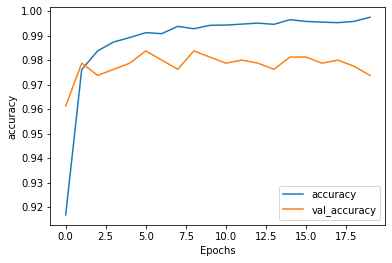

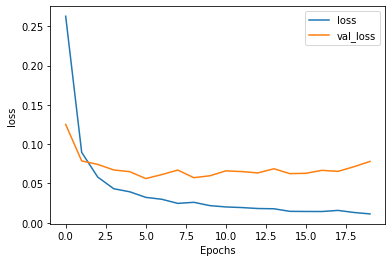

In [9]:
import matplotlib.pyplot as plt

def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## Evaluation on Test Data

In [10]:
test_data = ImageDataGenerator().flow_from_directory(directory= '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test',
                                                    target_size = tuple(IMG_SIZE),
                                                    shuffle = True,
                                                     class_mode = 'categorical')
model.evaluate(test_data)

Found 992 images belonging to 2 classes.
31/31 [==============================] - 7s 230ms/step - loss: 0.6959 - accuracy: 0.7621


[0.6959227323532104, 0.7620967626571655]

## Prediction on Model

(224, 224, 3)
(1, 224, 224, 3)
[1]
0.00018727941
0.9998128


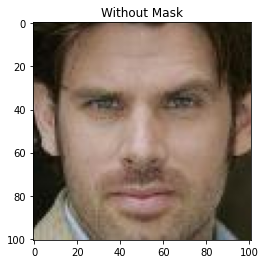

In [11]:
model = load_model("../input/facemaskdetectionmodelsoftmax/face_mask-2.h5")

IMG_SIZE = [224, 224]

pred_img_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1202.png'
image = tf.keras.preprocessing.image.load_img(path=pred_img_dir,
                                             target_size=tuple(IMG_SIZE))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
print(input_arr.shape)
input_arr = np.array([input_arr])  # Convert single image to a batch.
print(input_arr.shape)
predictions = model.predict(input_arr)
print(np.argmax(predictions, axis=1))
# print(predictions)
for i in predictions[0]:
    print(i)

# Image Display and Prediction
if np.argmax(predictions, axis = 1) == 1:
    plt.title('Without Mask')
else:
    plt.title("With Mask")
plt.imshow(plt.imread(pred_img_dir))

(224, 224, 3)
(1, 224, 224, 3)
[0]
0.9707065
0.029293446


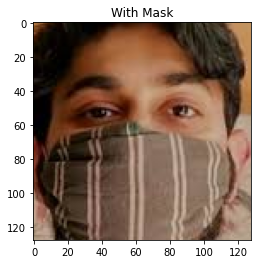

In [15]:
pred_img_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1175.png'
image = tf.keras.preprocessing.image.load_img(path=pred_img_dir,
                                             target_size=tuple(IMG_SIZE))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
print(input_arr.shape)
input_arr = np.array([input_arr])  # Convert single image to a batch.
print(input_arr.shape)
predictions = model.predict(input_arr)
print(np.argmax(predictions, axis=1))
# print(predictions)
for i in predictions[0]:
    print(i)

# Image Display and Prediction
if np.argmax(predictions, axis = 1) == 1:
    plt.title('Without Mask')
else:
    plt.title("With Mask")
plt.imshow(plt.imread(pred_img_dir))